In [205]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import importlib
from cycler import cycler
from pathlib import Path
from matplotlib.ticker import MultipleLocator
from pathlib import Path
from numpy.polynomial.polynomial import Polynomial
import re
from scipy.integrate import simpson
from matplotlib.lines import Line2D
from scipy.constants import e as q_e, m_e

# import utils
# importlib.reload(utils)

In [206]:
counter_voltages = [1, 2, 3]
columns = ['Counter Voltage', 'y value']
data_dict = {}
for v in counter_voltages:
    data_dict[f'{v}V'] = []
    file_path = Path(f'Data/task1-3_{v}v.txt')
    if not file_path.exists():
        raise FileNotFoundError(f"File {file_path} does not exist.")
    df = pd.read_csv(file_path, sep=r'\s+', header=None, names=columns)
    # df = df.dropna(axis=1, how='all')

    data_dict[f'{v}V'] = df

In [207]:
for key, df in data_dict.items():
    original_len = len(df)
    df = df[df['Counter Voltage'] != 0].reset_index(drop=True)
    data_dict[key] = df
    print(f"{key}: removed {original_len - len(df)} rows with Counter Voltage = 0")


1V: removed 1 rows with Counter Voltage = 0
2V: removed 0 rows with Counter Voltage = 0
3V: removed 0 rows with Counter Voltage = 0


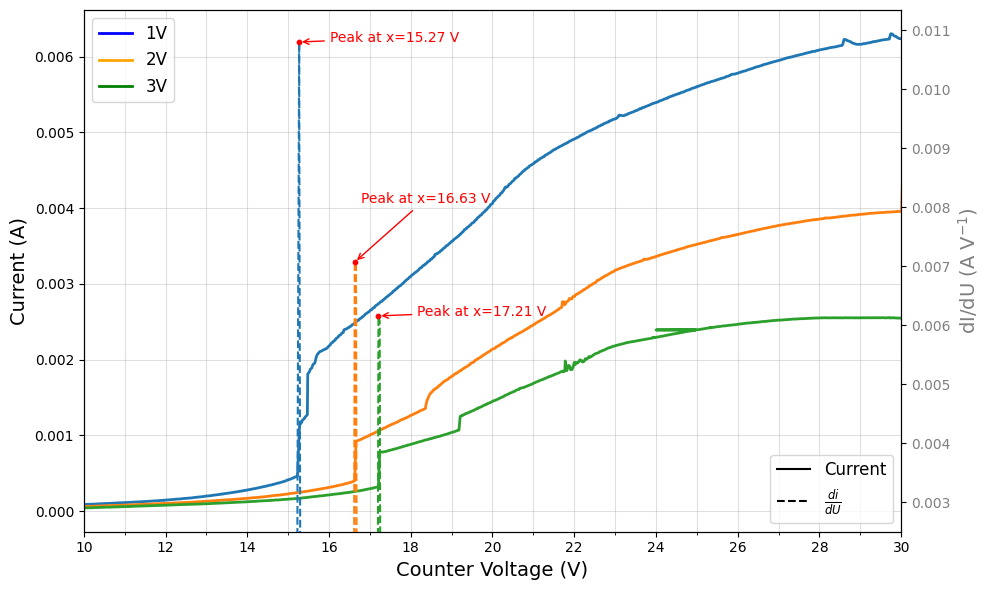

In [213]:
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()                # ❶  create the secondary axis only once
ionization_energies = pd.DataFrame(columns=['Voltage', 'Ionization Energy'])
for key, data in data_dict.items():
        # --- clean NaNs ---
    x = data['Counter Voltage'].values
    y = data['y value'].values
    mask = ~np.isnan(y)
    x_clean, y_clean = x[mask], y[mask]

    # --------------- current ---------------
    ax1.plot(x_clean, y_clean, lw=2, label=f'I   {key}')

    # --------------- derivative (restricted range) ---------------
    xmin, xmax = 15.04, 17.5
    m = (x_clean >= xmin) & (x_clean <= xmax)
    x_deriv, y_deriv = x_clean[m], y_clean[m]

    if len(x_deriv) > 1:                         # avoid empty slice
        threshold = 0.00

        dy_dx = np.gradient(y_deriv, x_deriv)
        strong_signal = dy_dx > threshold
        x_peak = x_deriv[strong_signal]
        #y_peak = y_deriv[strong_signal]
        dy_dx_peak = dy_dx[strong_signal]
        #from scipy.ndimage import gaussian_filter1d
        #dy_dx = gaussian_filter1d(dy_dx, sigma=1)

        # Find the maximum derivative value
        max_deriv = np.max(dy_dx_peak)
        max_index = np.argmax(dy_dx_peak)
        if key == '1V':
            # Find the second peak
            mask_low, mask_high = 15, 15.35
            second_peak_mask = (x_peak > mask_low) & (x_peak < mask_high)
            second_peak_x = x_peak[second_peak_mask]
            second_peak_y = dy_dx_peak[second_peak_mask]
            second_peak_max_index = np.argmax(second_peak_y)
            second_peak_x_value = second_peak_x[second_peak_max_index]
            second_peak_y_value = second_peak_y[second_peak_max_index]

            ax2.scatter(second_peak_x_value, second_peak_y_value, color='red', s=10, zorder=5,)
            ax2.annotate(f'Peak at x={second_peak_x_value:.2f} V',
                         xy=(second_peak_x_value, second_peak_y_value),
                        xytext=(second_peak_x_value + 0.75, second_peak_y_value),
                        arrowprops=dict(arrowstyle='->', color='red'),
                        fontsize=10, color='red')
            ax2.plot(second_peak_x, second_peak_y, '--',            # dashed style
                    label=f'dI/dU {key}')
            ionization_energies.loc[len(ionization_energies)] = {'Ionization Energy': second_peak_x_value,
                                                                 'Voltage': key.strip('V')}


        # "if key == '1V':
        #     deriv_df = pd.DataFrame({
        #         'Counter Voltage': x_peak,
        #         'Current': y_deriv,
        #         'dI/dU': dy_dx
        #     })
        #     print(deriv_df)"   
        if key == '2V':
            ax2.scatter(x_peak[max_index], max_deriv, color='red', s=10, zorder=5,)
            ax2.annotate(f'Peak at x={x_peak[max_index]:.2f} V',
                        xy=(x_peak[max_index], max_deriv),
                        xytext=(x_peak[max_index] + 0.15, max_deriv + 0.001),
                        arrowprops=dict(arrowstyle='->', color='red'),
                        fontsize=10, color='red')

            ax2.plot(x_peak, dy_dx_peak, '--',            # dashed style
                    label=f'dI/dU {key}')
            ionization_energies.loc[len(ionization_energies)] = {'Ionization Energy': x_peak[max_index],
                                                                 'Voltage': key.strip('V')}  
        elif key == '3V':
            ax2.scatter(x_peak[max_index], max_deriv, color='red', s=10, zorder=5,)
            ax2.annotate(f'Peak at x={x_peak[max_index]:.2f} V',
                        xy=(x_peak[max_index], max_deriv),
                        xytext=(x_peak[max_index] + 0.95, max_deriv),
                        arrowprops=dict(arrowstyle='->', color='red'),
                        fontsize=10, color='red')

            ax2.plot(x_deriv, dy_dx, '--',            # dashed style
                    label=f'dI/dU {key}')
            ionization_energies.loc[len(ionization_energies)] = {'Ionization Energy': x_peak[max_index],
                                                                 'Voltage': key.strip('V')}

       

# ---------- axis labels ----------
ax1.set_xlabel('Counter Voltage (V)', fontsize=14)
ax1.set_ylabel('Current (A)',          fontsize=14)
ax2.set_ylabel('dI/dU (A V$^{-1}$)',   fontsize=14, color='tab:gray')
ax2.tick_params(axis='y', labelcolor='tab:gray')
ax2.set_ylim(bottom=0.0025)
#ax2.set_yscale('log')

ax1.set_xlim(10, 30)
ax1.xaxis.set_major_locator(MultipleLocator(2))
ax1.xaxis.set_minor_locator(MultipleLocator(1))
#ax.grid(which='major', axis='both', alpha=0.35)
ax1.grid(True, which='both', ls='-', alpha=0.4)

voltage_handles = [
    Line2D([0], [0], color='blue', lw=2, label=r'1V'),
    Line2D([0], [0], color='orange',  lw=2, label=r'2V'),
    Line2D([0], [0], color='green',   lw=2, label=r'3V'),
]

# Custom legend for temperatures (marker shape)
type_handles = [
    Line2D([0], [0], color='black', marker=None, linestyle='-', label='Current'),
    Line2D([0], [0], color='black', marker=None, linestyle='--', label=r'$\frac{di}{dU}$')
]

# ---------- combined legend ----------
legend_elements = voltage_handles + type_handles
ax1.legend(handles=voltage_handles, loc='best', fontsize=12, ncol=1)
ax2.legend(handles=type_handles, loc='lower right', fontsize=12, ncol=1)


plt.tight_layout()
plt.show()


In [209]:
ionization_energies['Voltage'] = pd.to_numeric(ionization_energies['Voltage'], errors='coerce')
from IPython.display import display
display(ionization_energies)
print (ionization_energies.dtypes)

,Voltage,Ionization Energy
0,1,15.27
1,2,16.63
2,3,17.21


Voltage                int64
Ionization Energy    float64
dtype: object


In [210]:
def calc_real_ion_energy(U_acc, U_contact, U_counter):
    return(U_acc - U_contact - U_counter)

U_contact = 2.01 #1.78 (old value) # V (from Task 1)

ionization_energies['Real Ionization Energy'] = ionization_energies.apply(
    lambda row: calc_real_ion_energy(
        row['Ionization Energy'],
        U_contact,
        row['Voltage']
    ),
    axis=1
)


In [211]:
display(ionization_energies)
mean_ionization_energy = ionization_energies['Real Ionization Energy'].mean()
literature_value = 10.44
deviation = (mean_ionization_energy - literature_value) / literature_value * 100
print(f'Mean Ionization Energy: {mean_ionization_energy:.2f} V \n Litearture value: {literature_value}V (need to double check) \n Deviation: {deviation:.0f}%'  )

,Voltage,Ionization Energy,Real Ionization Energy
0,1,15.27,12.26
1,2,16.63,12.62
2,3,17.21,12.20


Mean Ionization Energy: 12.36 V 
 Litearture value: 10.44V (need to double check) 
 Deviation: 18%
